In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load pre-trained VGG16
model = vgg16(pretrained=True)
model.eval()


D:\Environment\Anaconda\envs\UNSW\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Environment\Anaconda\envs\UNSW\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate(self, input_tensor):
        # Forward pass
        output = self.model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][pred_class] = 1
        output.backward(gradient=one_hot)
        
        # Compute CAM
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.squeeze().cpu().numpy(), pred_class

# Select last convolutional layer
target_layer = model.features[28]  # Last conv layer in VGG16
gradcam = GradCAM(model, target_layer)

In [4]:
def preprocess_image(img_path):
    # Read and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    # Normalize for ImageNet-trained model
    tensor = torch.tensor(img).permute(2,0,1).float()
    tensor = tensor / 255.0
    tensor = (tensor - torch.tensor([0.485, 0.456, 0.406])[:, None, None]) / \
             torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return tensor.unsqueeze(0)  # Add batch dimension


In [5]:
def add_noise(image_tensor, intensity=0.1):
    noise = torch.randn_like(image_tensor) * intensity
    return torch.clamp(image_tensor + noise, 0, 1)

def add_blur(image_tensor, kernel_size=11):
    image_np = image_tensor.squeeze().permute(1,2,0).numpy()
    blurred = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return torch.tensor(blurred).permute(2,0,1).unsqueeze(0)

def add_occlusion(image_tensor, position=(100,100), size=50):
    occluded = image_tensor.clone()
    occluded[:, :, position[0]:position[0]+size, position[1]:position[1]+size] = 0
    return occluded

In [6]:
def visualize_results(original, perturbed, cam_original, cam_perturbed, pred_original, pred_perturbed):
    plt.figure(figsize=(12, 6))
    
    # Original image and CAM
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title(f"Original Image\nPred: {pred_original}")
    
    plt.subplot(2, 3, 2)
    plt.imshow(cam_original, cmap='jet')
    plt.title("Original CAM")
    
    plt.subplot(2, 3, 3)
    plt.imshow(original)
    plt.imshow(cam_original, cmap='jet', alpha=0.5)
    plt.title("Overlay")
    
    # Perturbed image and CAM
    plt.subplot(2, 3, 4)
    plt.imshow(perturbed)
    plt.title(f"Perturbed Image\nPred: {pred_perturbed}")
    
    plt.subplot(2, 3, 5)
    plt.imshow(cam_perturbed, cmap='jet')
    plt.title("Perturbed CAM")
    
    plt.subplot(2, 3, 6)
    plt.imshow(perturbed)
    plt.imshow(cam_perturbed, cmap='jet', alpha=0.5)
    plt.title("Overlay")
    
    plt.tight_layout()
    plt.show()

# Full analysis pipeline
def analyze_robustness(img_path):
    # Process original image
    original_tensor = preprocess_image(img_path)
    cam_original, pred_original = gradcam.generate(original_tensor)
    
    # Create perturbed image
    perturbed_tensor = add_occlusion(add_blur(add_noise(original_tensor)))
    
    # Process perturbed image
    cam_perturbed, pred_perturbed = gradcam.generate(perturbed_tensor)
    
    # Visualize
    original_img = original_tensor.squeeze().permute(1,2,0).numpy()
    perturbed_img = perturbed_tensor.squeeze().permute(1,2,0).numpy()
    visualize_results(original_img, perturbed_img, 
                     cam_original, cam_perturbed,
                     pred_original, pred_perturbed)

D:\Environment\Anaconda\envs\UNSW\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5185376..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5185376..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


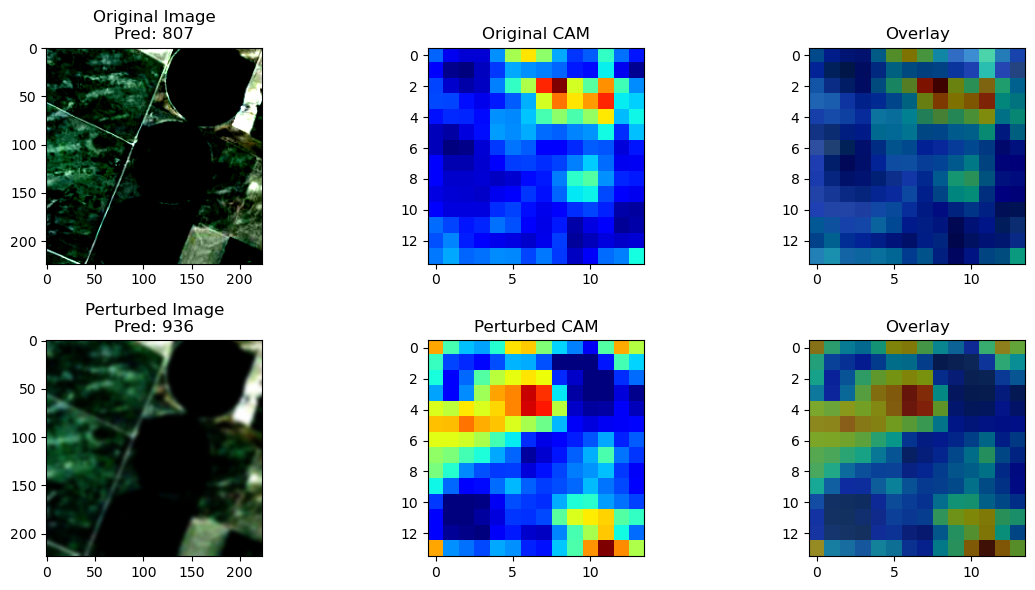

In [7]:
analyze_robustness("../../archive/Aerial_Landscapes/Agriculture/022.jpg")